## LightGBM

앞서 배운 XGBoost도 여전히 GridSearchCV 로 하이퍼 파라미터를 튜닝 시키면 수행 시간이 너무 오래 걸린다.<br>
물론 GBM 보다는 빠르지만 많은 CPU 코어를 가진 시스템에서 높은 병렬도로 학습을 진행하는 게 아니라면 여전히 수행 시간이 오래 걸리는 셈이다.<br><br>
LightGBM 은 이 문제를 해결해 준다. 장단점을 살펴보자.<br> 
* XGBoost 보다 빠른 속도
* 메모리 사용량도 상대적으로 적음 
* 카테고리형 feature 의 자동 변환과 최적 분할 ( 인코딩 필요 X )
* XGBoost 와 성능 차이는 크게 없음
* 적은 데이터 세트, 약 10000건 이하 정도에 적용 할 경우 과적합이 발생하기 쉽기 때문에 일반적으로 대용량 데이터에 적용하는 것이 맞음

### LightGBM vs 일반 GBM 계열
[참고 이미지 자료](https://user-images.githubusercontent.com/58713684/97020669-cafb3e80-158c-11eb-95c8-f2ef94438bfc.png)<br>

<u>일반 GBM 계열</u> - 균할 트리 분할 (Level Wise)<br>

   * 최대한 <span style="color:red">균형 잡힌 트리를 유지하면서 분할</span>하기 때문에 트리의 깊이를 효과적으로 최소화하는 알고리즘 = AVL tree [정리해둔 자료구조 참고]
   * 오버피팅 = 과적합 에 보다 더 강한 구조를 가짐
   * 균형을 맞추기 위한 시간 필요
    
<u>LightGBM</u> - 리프 중심 트리 분할 (Leaf Wise)<br>
    
   * <span style="color:red">최대 손실 값(max delta loss) 을 가지는 리프 노드를 지속적으로 분할</span>하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리 생성 
   * 이 규칙 트리는 학습을 반복 할수록 결국 균형 트리 분할 방식보다 예측 오류 손실을 최소화 해줄 수 있음. 
   
### LightGBM 하이퍼 파라미터 
 
LightGBM 도 마찬가지로 <u>파이썬 래퍼 LightGBM</u> 과 <u>사이킷런 래퍼 LightGBM</u> 으로 나뉜다. <br>자세한 것은 넘어가고 하이퍼 파라미터가 어떻게 구성되는 지 확인하자.

__파이썬 래퍼 LightGBM 하이퍼 파라미터__
* p.247 ~ 249 참고<br>
* [공식 문서](https://lightgbm.readthedocs.io/en/latest/Parameters.html)
* [참고 자료](https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/)

__사이킷런 래퍼 LightGBM 하이퍼 파라미터__

* p.250 
* [공식 문서](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMModel.html)
* [참고 이미지 자료 - (좌) 파이썬 래퍼 (우) 사이킷런 래퍼](https://media.vlpt.us/images/dbj2000/post/d00f4ce6-7259-4515-871b-04c442a1b9f4/image.png)



__기본 튜닝 방안 (파이썬 래퍼 파라미터 명칭 기준)__
* num_leaves 는 개별 트리가 가질 수 있는 최대 리프의 갯수. 갯수를 높이면 정확도가 높아지지만 , 트리의 깊이가 깊어져서 과적합 영향도가 커짐.<br><br>
* min_data_in_leaf 는 과적합 개선을 위한 파라미터. num_leave 와 학습 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지<br><br>
* max_depth 는 명시적으로 트리의 깊이를 제한하는 파라미터. 위 파라미터 2개와 함께 과적합 개선에 유용 

앞서 XGBoost 에서 사용했던 classifier_evaluation 함수와 위스콘신 유방암 데이터셋으로 예제를 진행한다.

In [7]:
# 사이킷런 래퍼 LightGBM 사용 
from lightgbm import LGBMClassifier
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
feature = dataset.data
label = dataset.target

X_train, X_test , y_train,y_test = train_test_split(feature,label,test_size=0.2,random_state=133)

lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(X_test,y_test)]

lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)

pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

# ------------------------------------------------------------------------------------------------------------
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# 여러 가지 성능 평가 지표 값을 보여주는 함수
def classifier_evaluation(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
        
    roc_auc = roc_auc_score(y_test,pred_proba)
        
    print('오차 행렬')
    print(confusion)
        
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc),
          '\n\n')
    return ;
# ----------------------------------------------------------------------------------------------------------------------------

[1]	valid_0's binary_logloss: 0.569899
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.509404
[3]	valid_0's binary_logloss: 0.461118
[4]	valid_0's binary_logloss: 0.418776
[5]	valid_0's binary_logloss: 0.38387
[6]	valid_0's binary_logloss: 0.352768
[7]	valid_0's binary_logloss: 0.326446
[8]	valid_0's binary_logloss: 0.302634
[9]	valid_0's binary_logloss: 0.280808
[10]	valid_0's binary_logloss: 0.261356
[11]	valid_0's binary_logloss: 0.243259
[12]	valid_0's binary_logloss: 0.226606
[13]	valid_0's binary_logloss: 0.214459
[14]	valid_0's binary_logloss: 0.202529
[15]	valid_0's binary_logloss: 0.190828
[16]	valid_0's binary_logloss: 0.180793
[17]	valid_0's binary_logloss: 0.170278
[18]	valid_0's binary_logloss: 0.162215
[19]	valid_0's binary_logloss: 0.155871
[20]	valid_0's binary_logloss: 0.149839
[21]	valid_0's binary_logloss: 0.144382
[22]	valid_0's binary_logloss: 0.139891
[23]	valid_0's binary_logloss: 0.136321
[24]	valid_0's binary_loglos

In [8]:
classifier_evaluation(y_test,pred,pred_proba)

오차 행렬
[[36  3]
 [ 1 74]]
정확도: 0.9649, 정밀도: 0.9610, 재현율: 0.9867, F1: 0.9737, AUC: 0.9983 




XGBoost 의 예측 성능 지표와 큰 차이가 없는데, dataset 크기 자체가 별로 크지 않기 때문에 알고리즘 간 성능 비교를 그다지 의미가 없다.<br>
마지막 피처 중요도 그래프 코드는 XGBoost 때와 동일하다.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

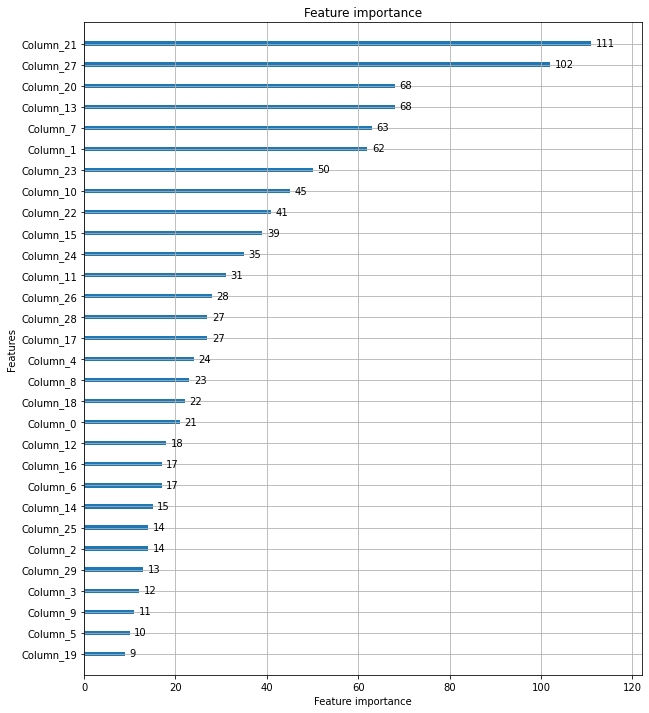

In [10]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt 
%matplotlib inline 

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax= ax)

한 가지 짚고 넘어가자. <br><br>
Classifiaction 에서 
 * __파이썬 wrapper__ 일 경우 : import lightgbm / import xgboost <br>
 * __사이킷런 wrapper__ 일 경우 : from lightgbm import LGBMClassifier / from xgboost import XGBClassifier <br>
 
처럼 사용한다. 즉 두 wrapper 모두 결국 하나의 모듈에 모아져 있다. 사용 할 때 구분해서 사용하자.